In [1]:
import FicherosComun as fc
import BusquedaLocal as bl
import AlgoritmoComparacionGreedy as greedy
import csv

# Practica 2
import GRASP
import ILS
import VNS

# Colores ANSI
RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

NombreArchivos = ["DataSets/tai25b.dat", "DataSets/sko90b.dat", "DataSets/tai150b.dat"]
Cos_tai25b = 344355646
Cos_sko90b = 115534
Cos_tai150b = 498896643
CostoSoluciones = [Cos_tai25b, Cos_sko90b, Cos_tai150b]

semillas = [769123, 8435, 423543, 656343, 80987]

contador_algoritmos_ejecutados = 0

def crear_encabezado_csv():
    with open("resultados_grafica_P2.csv", "w", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(["Archivo", "Algoritmo", "Semilla", "Mejor Solucion", "Costo", "Costo Optimo", "Historial de Costos", "Evaluaciones", "Distancias"])
    with open("resultados_P2.csv", "w", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(["Archivo", "Algoritmo", "Semilla", "Costo", "Evaluaciones"])

def escribir_resultados(archivo, algoritmo, semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones, distancias):
    global contador_algoritmos_ejecutados
    with open("resultados_grafica_P2.csv", "a", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow([archivo, algoritmo, semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones, distancias])
        archivo_csv.flush()

    with open("resultados_P2.csv", "a", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow([archivo, algoritmo, semilla, mejor_costo, evaluaciones])
        archivo_csv.flush()

    contador_algoritmos_ejecutados += 1

def ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, costo_optimo):
    try:
        mejor_solucion, mejor_costo, historial_costos, evaluaciones = bl.busqueda_local_primer_mejor(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda Local del Primer Mejor", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones, [])

        mejor_solucion, mejor_costo, historial_costos, evaluaciones, distacias_VNS = VNS.vns_qap(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda VNS", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones, [])

    except Exception as e:
        print(f"Ocurrió un error: {e}")

for i, nombre_archivo in enumerate(NombreArchivos):
    print(f"{GREEN}Ejecucion de {nombre_archivo} iniciada{RESET}")

    if i == 0:
        crear_encabezado_csv()

    distancia, flujo, n = fc.leer_archivo_y_extraer_matrices(nombre_archivo)

    mejor_solucion, mejor_costo, evaluaciones = greedy.greedy_qap(distancia, flujo, n)
    escribir_resultados(nombre_archivo, "Greedy", "N/A", mejor_solucion, mejor_costo, CostoSoluciones[i], [], evaluaciones, [])

    mejor_solucion, mejor_costo,historial_costos ,evaluaciones, distancias_Grasp = GRASP.grasp_qap(distancia, flujo, n, semillas[0])
    escribir_resultados(nombre_archivo, "Busqueda GRASP (BL)", semillas[0], mejor_solucion, mejor_costo, CostoSoluciones[i], historial_costos, evaluaciones, distancias_Grasp)

    # Gasp greedy sin bl
    mejor_solucion, mejor_costo,historial_costos ,evaluaciones, distancias_Grasp = GRASP.grasp_qap(distancia, flujo, n, semillas[0], True)
    escribir_resultados(nombre_archivo, "Busqueda GRASP (Puro)", semillas[0], mejor_solucion, mejor_costo, CostoSoluciones[i], historial_costos, evaluaciones, distancias_Grasp)

    mejor_solucion, mejor_costo, historial_costos, evaluaciones, distancias_ILS = ILS.ils_qap(distancia, flujo, n, semillas[0])
    escribir_resultados(nombre_archivo, "Busqueda ILS", semillas[0], mejor_solucion, mejor_costo, CostoSoluciones[i], historial_costos, evaluaciones, [])

    for semilla in semillas:
        ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, CostoSoluciones[i])

    print(f"{RED}Ejecucion de {nombre_archivo} finalizada{RESET}")


Ejecucion de DataSets/tai25b.dat iniciada
Ejecucion de DataSets/tai25b.dat finalizada
Ejecucion de DataSets/sko90b.dat iniciada
Ejecucion de DataSets/sko90b.dat finalizada
Ejecucion de DataSets/tai150b.dat iniciada
Ejecucion de DataSets/tai150b.dat finalizada


C:\Users\kjba2\AppData\Local\Temp\ipykernel_1836\2349466443.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (archivo, algoritmo), grupo in df.groupby(["Archivo", "Algoritmo"], sort=False):


-----------------------------------------------------------------
DataSet: DataSets/tai25b.dat
Algoritmo: Busqueda GRASP (BL)
Semilla: 769123.0 - Costo: 348466729 - Evaluaciones: 37217


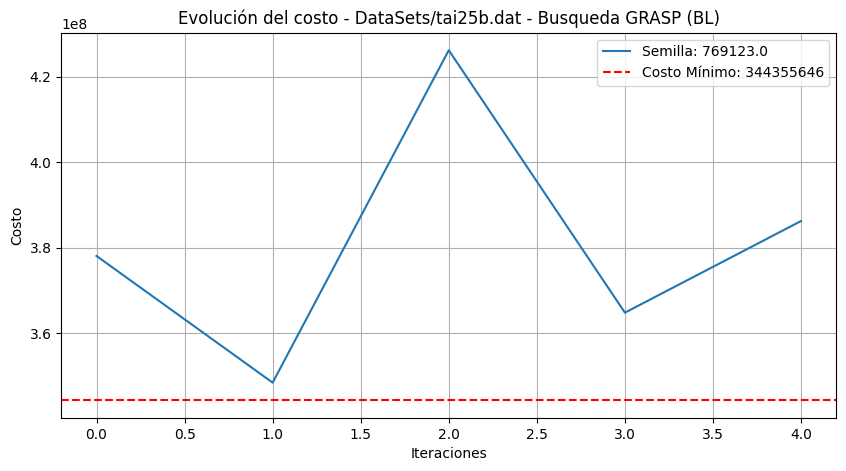

-----------------------------------------------------------------
DataSet: DataSets/tai25b.dat
Algoritmo: Busqueda GRASP (Puro)
Semilla: 769123.0 - Costo: 779942000 - Evaluaciones: 5


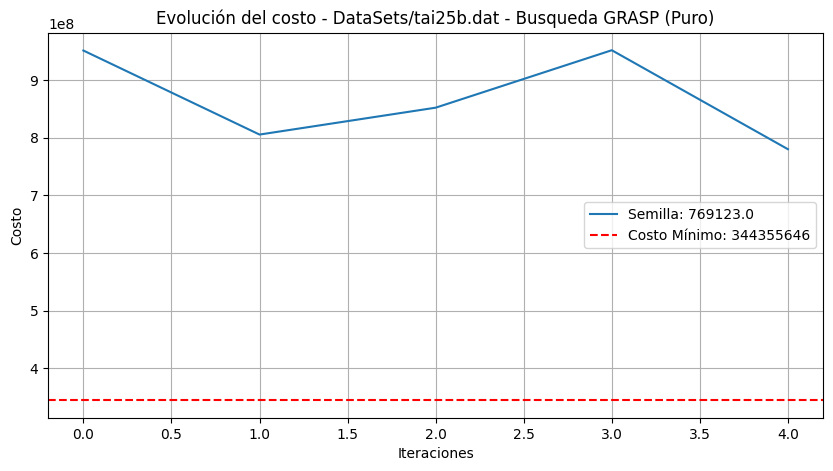

-----------------------------------------------------------------
DataSet: DataSets/tai25b.dat
Algoritmo: Busqueda ILS
Semilla: 769123.0 - Costo: 394964292 - Evaluaciones: 25898


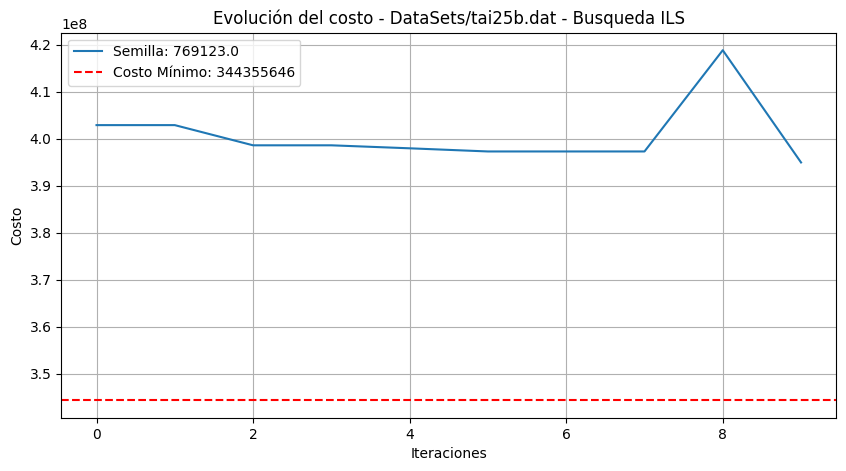

-----------------------------------------------------------------
DataSet: DataSets/tai25b.dat
Algoritmo: Busqueda Local del Primer Mejor
Semilla: 769123.0 - Costo: 402914653 - Evaluaciones: 4762
Semilla: 8435.0 - Costo: 382736549 - Evaluaciones: 4979
Semilla: 423543.0 - Costo: 367030385 - Evaluaciones: 5876
Semilla: 656343.0 - Costo: 368379802 - Evaluaciones: 7706
Semilla: 80987.0 - Costo: 435271658 - Evaluaciones: 5671


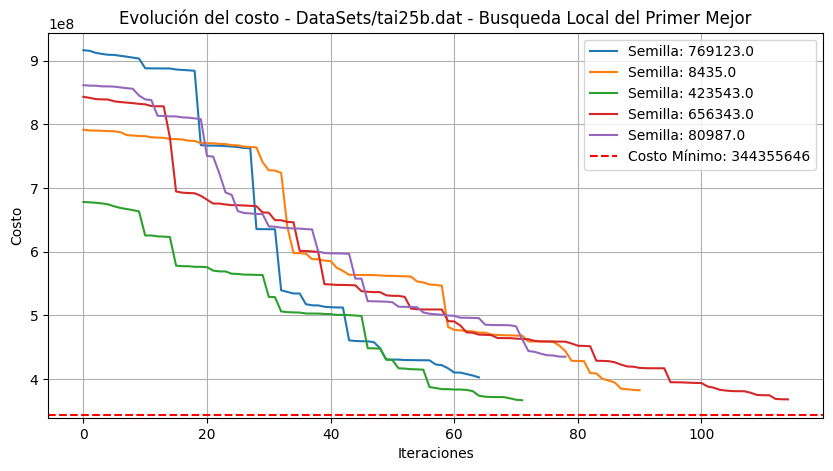

-----------------------------------------------------------------
DataSet: DataSets/tai25b.dat
Algoritmo: Busqueda VNS
Semilla: 769123.0 - Costo: 385349045 - Evaluaciones: 18901
Semilla: 8435.0 - Costo: 380034200 - Evaluaciones: 22196
Semilla: 423543.0 - Costo: 365884856 - Evaluaciones: 18464
Semilla: 656343.0 - Costo: 347174156 - Evaluaciones: 21561
Semilla: 80987.0 - Costo: 368292789 - Evaluaciones: 18580


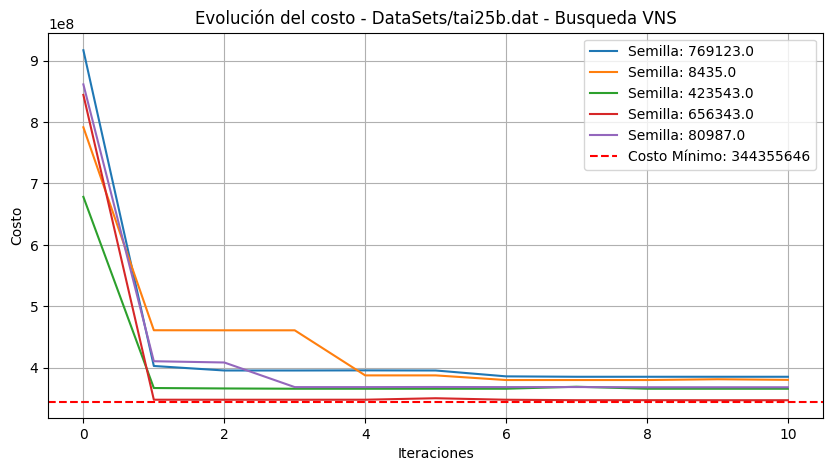

-----------------------------------------------------------------
DataSet: DataSets/tai25b.dat
Algoritmo: Greedy
Semilla: nan - Costo: 913427707 - Evaluaciones: 1
-----------------------------------------------------------------
DataSet: DataSets/sko90b.dat
Algoritmo: Busqueda GRASP (BL)
Semilla: 769123.0 - Costo: 116764 - Evaluaciones: 3256778


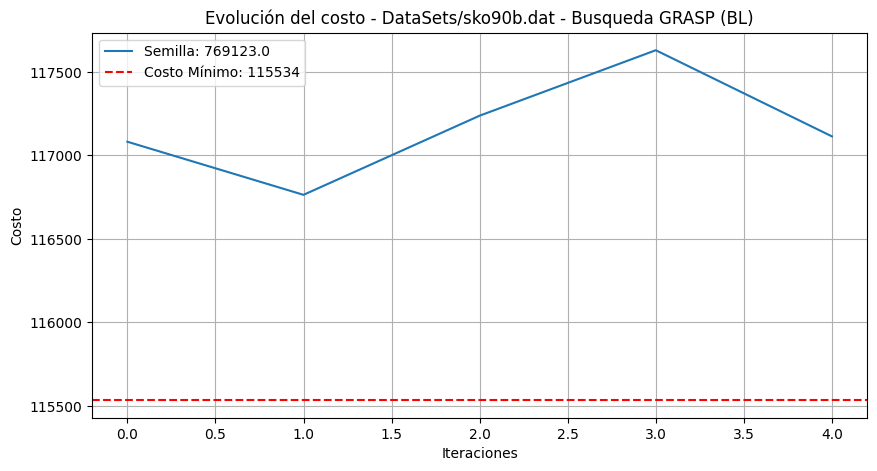

-----------------------------------------------------------------
DataSet: DataSets/sko90b.dat
Algoritmo: Busqueda GRASP (Puro)
Semilla: 769123.0 - Costo: 135846 - Evaluaciones: 5


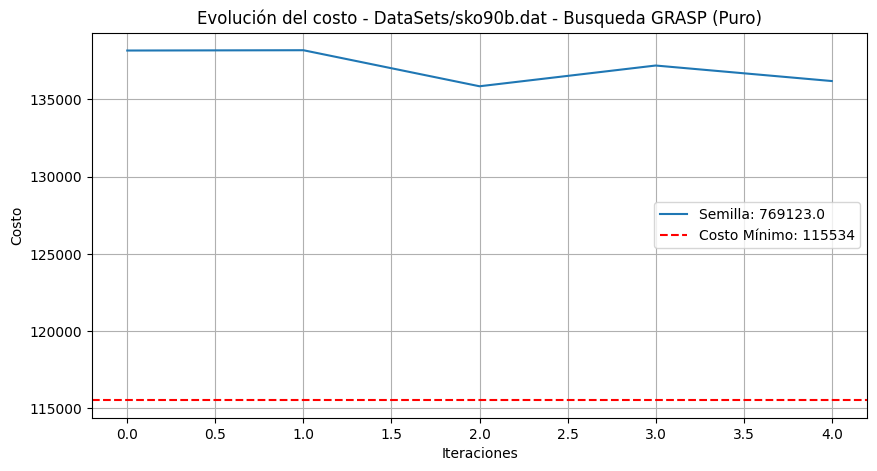

-----------------------------------------------------------------
DataSet: DataSets/sko90b.dat
Algoritmo: Busqueda ILS
Semilla: 769123.0 - Costo: 116652 - Evaluaciones: 3341913


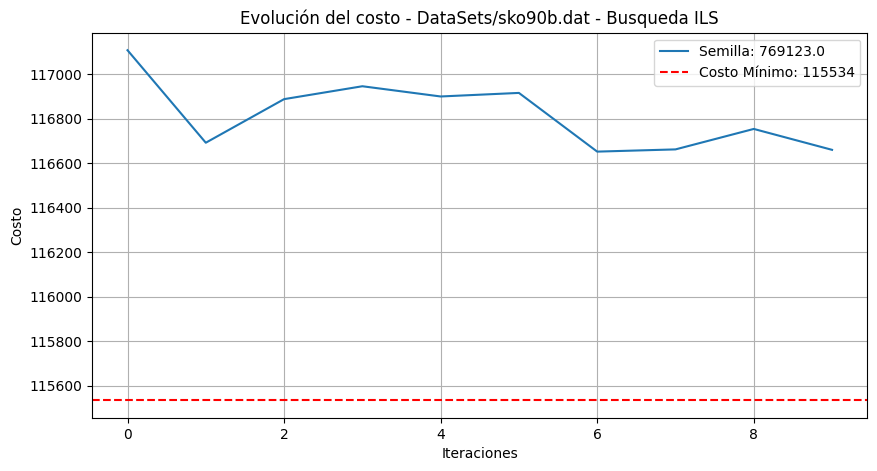

-----------------------------------------------------------------
DataSet: DataSets/sko90b.dat
Algoritmo: Busqueda Local del Primer Mejor
Semilla: 769123.0 - Costo: 117108 - Evaluaciones: 566027
Semilla: 8435.0 - Costo: 117190 - Evaluaciones: 789150
Semilla: 423543.0 - Costo: 117030 - Evaluaciones: 659400
Semilla: 656343.0 - Costo: 118296 - Evaluaciones: 582754
Semilla: 80987.0 - Costo: 117038 - Evaluaciones: 754970


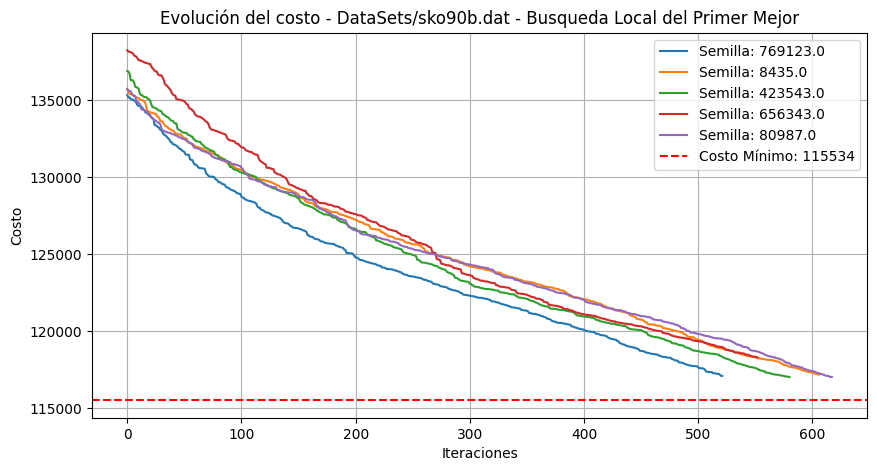

-----------------------------------------------------------------
DataSet: DataSets/sko90b.dat
Algoritmo: Busqueda VNS
Semilla: 769123.0 - Costo: 116170 - Evaluaciones: 2303192
Semilla: 8435.0 - Costo: 116640 - Evaluaciones: 1780307
Semilla: 423543.0 - Costo: 116228 - Evaluaciones: 2503137
Semilla: 656343.0 - Costo: 117008 - Evaluaciones: 2430388
Semilla: 80987.0 - Costo: 116356 - Evaluaciones: 2370082


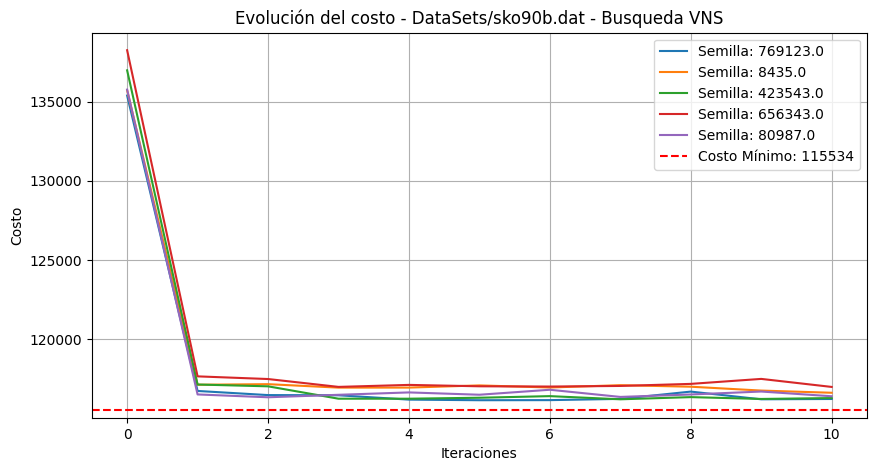

-----------------------------------------------------------------
DataSet: DataSets/sko90b.dat
Algoritmo: Greedy
Semilla: nan - Costo: 136080 - Evaluaciones: 1
-----------------------------------------------------------------
DataSet: DataSets/tai150b.dat
Algoritmo: Busqueda GRASP (BL)
Semilla: 769123.0 - Costo: 508342309 - Evaluaciones: 23272476


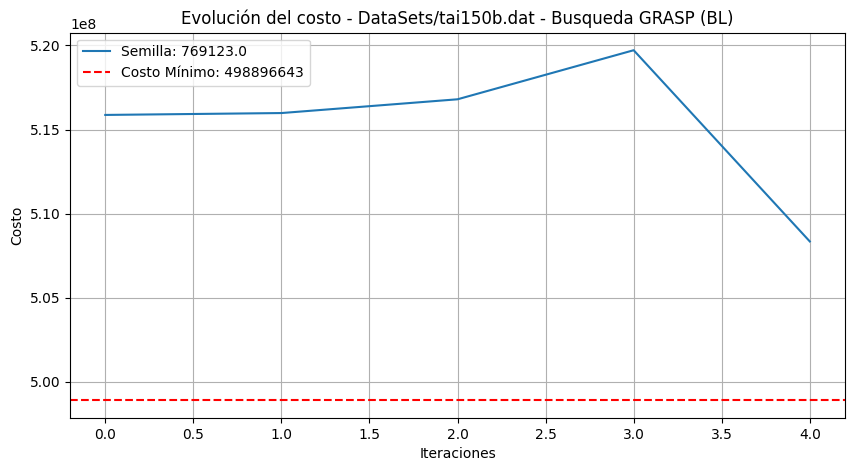

-----------------------------------------------------------------
DataSet: DataSets/tai150b.dat
Algoritmo: Busqueda GRASP (Puro)
Semilla: 769123.0 - Costo: 645333882 - Evaluaciones: 5


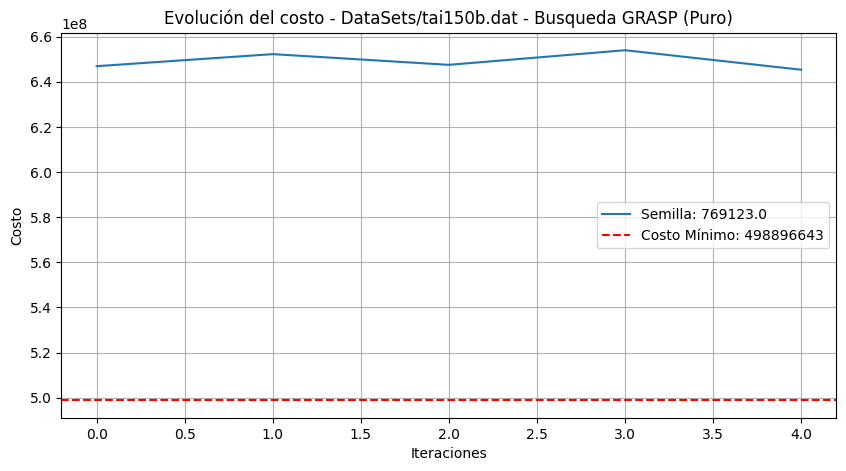

-----------------------------------------------------------------
DataSet: DataSets/tai150b.dat
Algoritmo: Busqueda ILS
Semilla: 769123.0 - Costo: 502716427 - Evaluaciones: 22950416


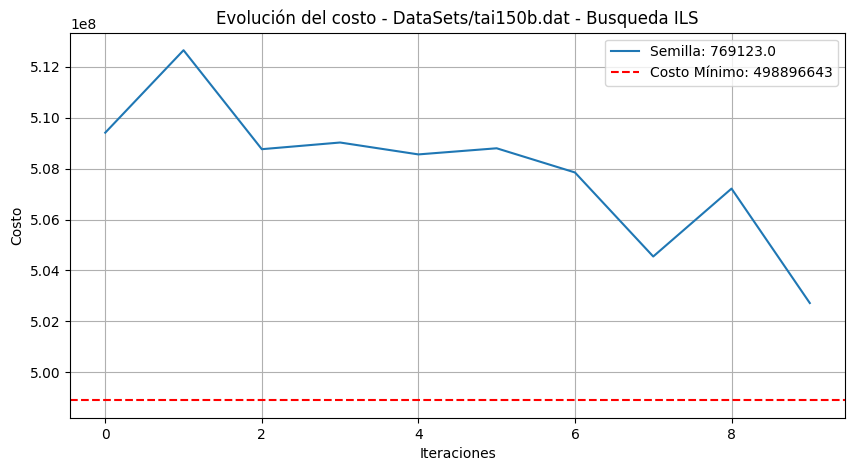

-----------------------------------------------------------------
DataSet: DataSets/tai150b.dat
Algoritmo: Busqueda Local del Primer Mejor
Semilla: 769123.0 - Costo: 509412789 - Evaluaciones: 4465263
Semilla: 8435.0 - Costo: 510018713 - Evaluaciones: 6482436
Semilla: 423543.0 - Costo: 509920849 - Evaluaciones: 6304166
Semilla: 656343.0 - Costo: 512367226 - Evaluaciones: 5643033
Semilla: 80987.0 - Costo: 513780289 - Evaluaciones: 5159328


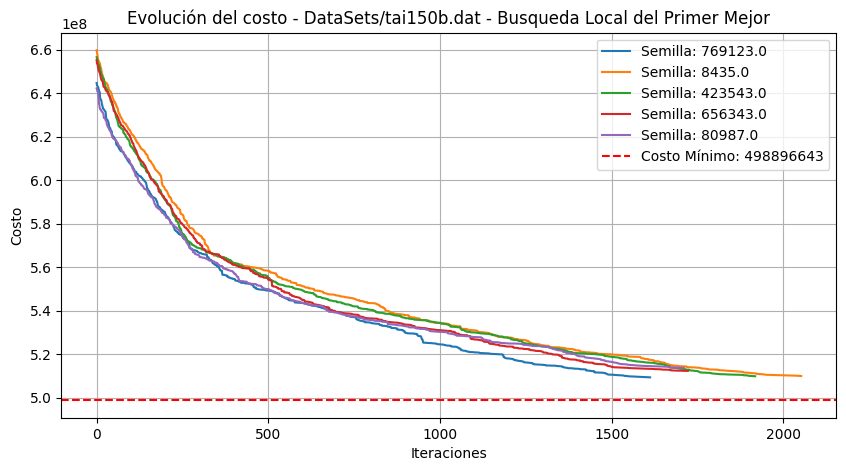

-----------------------------------------------------------------
DataSet: DataSets/tai150b.dat
Algoritmo: Busqueda VNS
Semilla: 769123.0 - Costo: 509618860 - Evaluaciones: 17537008
Semilla: 8435.0 - Costo: 512658799 - Evaluaciones: 13538759
Semilla: 423543.0 - Costo: 508210225 - Evaluaciones: 14918236
Semilla: 656343.0 - Costo: 507700630 - Evaluaciones: 17688571
Semilla: 80987.0 - Costo: 512457158 - Evaluaciones: 13300430


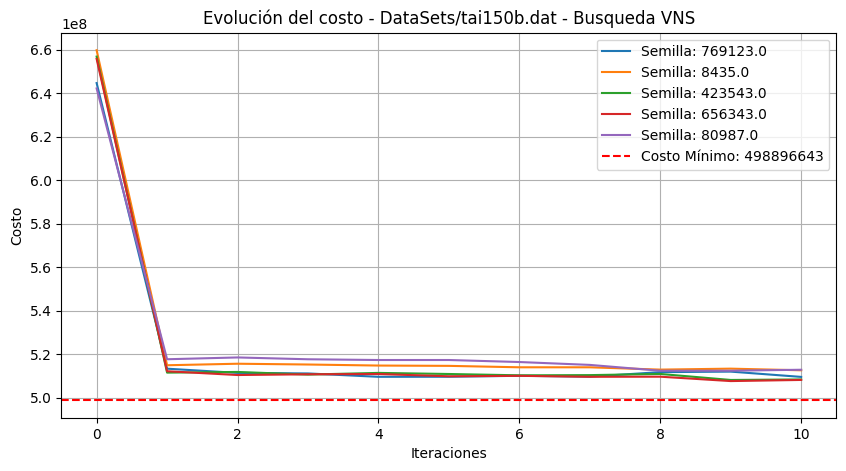

-----------------------------------------------------------------
DataSet: DataSets/tai150b.dat
Algoritmo: Greedy
Semilla: nan - Costo: 653315921 - Evaluaciones: 1


In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import FicherosComun as fc
import LaTexGenerator as LG

# Colores ANSI para resaltar texto
RED = "\033[91m"
CYAN = "\033[96m"
GREEN = "\033[92m"
RESET = "\033[0m"

# Orden deseado de los archivos
NombreArchivos = ["DataSets/tai25b.dat", "DataSets/sko90b.dat", "DataSets/tai150b.dat"]
# Costos mínimos de referencia
CostoSoluciones = {
    "DataSets/tai25b.dat": 344355646,
    "DataSets/sko90b.dat": 115534,
    "DataSets/tai150b.dat": 498896643
}

def leer_y_representar_resultados(nombre_archivo):
    df = pd.read_csv(nombre_archivo)
    df["Semilla"] = df["Semilla"].apply(lambda x: int(x) if str(x).isdigit() else x)

    def convertir_a_lista(x):
        try:
            x = x.replace("np.int64(", "").replace(")", "")
            return ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else []
        except (ValueError, SyntaxError):
            return []

    df["Historial de Costos"] = df["Historial de Costos"].apply(convertir_a_lista)

    df["Archivo"] = pd.Categorical(df["Archivo"], categories=NombreArchivos, ordered=True)
    df = df.sort_values(by=["Archivo", "Algoritmo"])

    for (archivo, algoritmo), grupo in df.groupby(["Archivo", "Algoritmo"], sort=False):
        print("-----------------------------------------------------------------")
        print(f"{RED}DataSet: {archivo}{RESET}")
        print(f"{CYAN}Algoritmo: {algoritmo}{RESET}")

        # Verificar si hay al menos un historial válido en el grupo
        hay_historial = any(
            isinstance(fila["Historial de Costos"], list) and len(fila["Historial de Costos"]) > 0
            for _, fila in grupo.iterrows()
        )

        if hay_historial:
            plt.figure(figsize=(10, 5))
            plt.title(f"Evolución del costo - {archivo} - {algoritmo}")
            plt.xlabel("Iteraciones")
            plt.ylabel("Costo")

        for _, fila in grupo.iterrows():
            print(f"{GREEN}Semilla: {fila['Semilla']}{RESET} - Costo: {fila['Costo']} - Evaluaciones: {fila['Evaluaciones']}")
            historial = fila["Historial de Costos"]

            if hay_historial and isinstance(historial, list) and len(historial) > 0:
                plt.plot(historial, label=f"Semilla: {fila['Semilla']}")

        if hay_historial:
            plt.axhline(y=CostoSoluciones[archivo], color='red', linestyle='--', label=f"Costo Mínimo: {CostoSoluciones[archivo]}")
            plt.legend()
            plt.grid()
            plt.show(block=False)

optimos = {k.split("/")[-1]: v for k, v in CostoSoluciones.items()}
            
# Generamos el fichero LaTex
LG.generar_tablas_latex("resultados_grafica_P2.csv", "tablas_resultados_P2.tex", "P2",optimos )

# Ejemplo de uso:
leer_y_representar_resultados("resultados_grafica_P2.csv")
